# 1. Ingesta de datos

In [2]:
#importamos librerías a usar
import pandas as pd
import numpy as np
import ast #Módulo para manejar evaluación de expresiones literales de python
import json
import pyarrow as pa
import pyarrow.parquet as pq
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns



In [3]:
#Leemos los datos

ruta1 = 'ds_inicial\credits.csv'
ruta2 = 'ds_inicial\movies_dataset.csv'


## 1.1 Movies
Se realiza lectura del data set Movies

In [4]:
df_movies = pd.read_csv(ruta2, low_memory=False)

In [5]:
df_movies.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0


In [5]:
df_movies['id'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 45466 entries, 0 to 45465
Series name: id
Non-Null Count  Dtype 
--------------  ----- 
45466 non-null  object
dtypes: object(1)
memory usage: 355.3+ KB


## 1.2 Credits
Se realiza lectura del dataset Credits

In [7]:
df_credits = pd.read_csv(ruta1)

In [8]:
df_credits.head(3)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602


In [9]:
df_credits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45476 entries, 0 to 45475
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   cast    45476 non-null  object
 1   crew    45476 non-null  object
 2   id      45476 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


# 2. Tratamiento de datos (ETL)

## 2.1 Desanidado de columnas

##### Luego de la ingesta de datos, se aprecia que los dos dataframes presenta columnas con datos anidados. por lo que se utilizará la función .explode, con el fin de desanidar la información y convertir cada clave a columna.

##### luego de desanidar, se concatenan las columnas deldata frame df_explode con las columnas desanidadas

### 2.1.1 df_movies

In [9]:
# se borra columna que no se utilizará de movies
df_movies = df_movies.rename(columns={'id': 'id_movie'})

def safe_literal_eval(x):
    try: 
        return ast.literal_eval(x) 
    except (ValueError, SyntaxError):
        return []
cols_a_literal = ['belongs_to_collection','genres','production_companies', 'production_countries', 'spoken_languages']

# Aplicar safe_literal_eval a cada columna si es necesario para poder llevarlo a explotar
for col in cols_a_literal:
    if col in df_movies.columns:
        df_movies[col] = df_movies[col].apply(lambda x: safe_literal_eval(x) if pd.notna(x) else pd.NA) 

cols_a_explotar = ['genres','production_companies', 'production_countries', 'spoken_languages']
#Ciclo for para poder explotar las columnas en lista
for i in cols_a_explotar:
    df_movies = df_movies.explode(i)


In [10]:
df_explode = df_movies.copy()
df_explode.shape

(419779, 24)

In [11]:
df_explode.head(3)

,adult,belongs_to_collection,budget,genres,homepage,id_movie,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"{'id': 16, 'name': 'Animation'}",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"{'iso_639_1': 'en', 'name': 'English'}",Released,NaN,Toy Story,False,7.7,5415.0
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"{'id': 35, 'name': 'Comedy'}",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"{'iso_639_1': 'en', 'name': 'English'}",Released,NaN,Toy Story,False,7.7,5415.0
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"{'id': 10751, 'name': 'Family'}",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"{'iso_639_1': 'en', 'name': 'English'}",Released,NaN,Toy Story,False,7.7,5415.0


In [12]:
# #eliminamos datos nulos y reseteamos el indice
df_explode.dropna(how='all', inplace =True)
df_explode.reset_index(inplace=True, drop=True)

#normalizamos información semiestructurada de tipo json a una tabla plana y quitamos valores nulos
belongs_to_collection = pd.json_normalize(df_movies['belongs_to_collection'].dropna(how = 'all'))
genres = pd.json_normalize(df_explode['genres'].dropna(how = 'all'))
production_companies = pd.json_normalize(df_explode['production_companies'].dropna(how = 'all'))
production_countries = pd.json_normalize(df_explode['production_countries'].dropna(how = 'all'))
spoken_languages = pd.json_normalize(df_explode['spoken_languages'].dropna(how = 'all'))

#Reseteamos indices
belongs_to_collection.reset_index(inplace=True, drop=True)
genres.reset_index(inplace=True, drop=True)
production_companies.reset_index(inplace=True, drop=True)
production_countries.reset_index(inplace=True, drop=True)
spoken_languages.reset_index(inplace=True, drop=True)

#se cambian nombres a columnas de 'id'
belongs_to_collection = belongs_to_collection.rename(columns ={'id' : 'id_franchise', 'name': 'collection_name'})
genres = genres.rename(columns={'id': 'id_genres', 'name': 'genres'})
production_companies = production_companies.rename(columns={'id': 'id_company', 'name':'production_companies'})
production_countries = production_countries.rename(columns={'iso_3166_1': 'country_code', 'name':'production_countries'})
spoken_languages = spoken_languages.rename(columns={'iso_639_1': 'language_code', 'name':'language'})
#concatenamos los dataframes
df_movies_full = (pd.concat([df_explode.drop(columns=['belongs_to_collection', 'genres', 'production_companies','production_countries', 'spoken_languages']), belongs_to_collection, genres, production_companies, production_countries, spoken_languages], axis=1)).dropna(how='all')
df_movies_full.shape

(419779, 31)

## 2.1.2 df_credits

##### Desanidamos la información que se encuentra en credits, columnas crew y cast

In [13]:
#Cambiamos nombre de columna id
df_credits = df_credits.rename(columns={'id': 'id_movie'})

#función para aplicar ast.litera_eval
def safe_literal_eval(x):
    try: 
        return ast.literal_eval(x) 
    except (ValueError, SyntaxError):
        return []
cols_a_literal = ['crew', 'cast']

# Aplicar safe_literal_eval a cada columna si es necesario para poder llevarlo a explotar
for col in cols_a_literal:
    if col in df_credits.columns:
        df_credits[col] = df_credits[col].apply(lambda x: safe_literal_eval(x) if pd.notna(x) else pd.NA) 

cols_a_explotar = ['crew', 'cast']
#Ciclo for para poder explotar las columnas en lista
for i in cols_a_explotar:
    df_credits = df_credits.explode(i)

In [14]:
df_explodec = df_credits.copy()
df_explodec.shape

(9484668, 3)

In [15]:
# #eliminamos datos nulos y reseteamos el indice
df_explodec.dropna(how='all', inplace =True)
df_explodec.reset_index(inplace=True, drop=True)

#normalizamos información semiestructurada de tipo json a una tabla plana y quitamos valores nulos
cast = pd.json_normalize(df_explodec['cast'].dropna(how = 'all'))
crew = pd.json_normalize(df_explodec['crew'].dropna(how = 'all'))

#Reseteamos indices
cast.reset_index(inplace=True, drop=True)
crew.reset_index(inplace=True, drop=True)

#Cambio de nombre de columnas 'id'
cast = cast.rename(columns={'id': 'id_actor', 'name': 'actor_name', 'profile_path': 'actor_profile_path', 'credit_id': 'cast_creditid'})
crew = crew.rename(columns={'id': 'id_member', 'name': 'member_name', 'profile_path': 'member_profile_path', 'credit_id': 'crew_creditid'})
#concatenamos los dataframes
df_credits_full = (pd.concat([df_explodec.drop(columns=['crew', 'cast']),crew, cast ], axis=1)).dropna(how='all')


In [16]:
df_credits_full.shape

(9484668, 16)

## 2.2 Dupllicados, valores nulos e inconsistencias

### 2.2.1 df_movies_full

In [18]:
df_movies_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 419779 entries, 0 to 419778
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   adult                 419779 non-null  object        
 1   budget                419779 non-null  object        
 2   homepage              128605 non-null  object        
 3   id_movie              419779 non-null  object        
 4   imdb_id               419714 non-null  object        
 5   original_language     419683 non-null  object        
 6   original_title        419779 non-null  object        
 7   overview              417270 non-null  object        
 8   popularity            419762 non-null  object        
 9   poster_path           419199 non-null  object        
 10  release_date          419588 non-null  datetime64[ns]
 11  revenue               419758 non-null  float64       
 12  runtime               419202 non-null  float64       
 13 

In [19]:
#rellenado de valores nulos en campos revenue y budget con 0.
df_movies_full['revenue'] = df_movies_full['revenue'].fillna(0)
df_movies_full['budget'] = df_movies_full['budget'].fillna(0)
df_movies_full.shape

(419779, 31)

In [20]:
#eliminalos los nulos de release_date
df_movies_full.dropna(subset=['release_date'], inplace=True)
df_movies_full.shape

(419588, 31)

In [21]:
# Convertimos la columna a date_time y si encuentra algun error, lo clasifica como NaT ((N)ot-(A)-(T)ime, equivalente del tiempo para NaN.)
df_movies_full['release_date'] = pd.to_datetime(df_movies_full['release_date'], errors='coerce')
#creamos columna 'release_year' extrayendo el año de release_date

df_movies_full['release_year'] = pd.to_datetime(df_movies_full['release_date'], errors='coerce').dt.year

In [22]:
df_movies_full[['release_date', 'release_year']].head(3)

,release_date,release_year
0,1995-10-30,1995
1,1995-10-30,1995
2,1995-10-30,1995


In [23]:
#verificados que los valores de las columnas revenue y budget sean numéricos
df_movies_full['revenue'] = pd.to_numeric(df_movies_full['revenue'], errors='coerce')
df_movies_full['budget'] = pd.to_numeric(df_movies_full['budget'], errors='coerce')

#Calculamos columna return como revenue/budget
df_movies_full['return'] = np.where(df_movies_full['budget'] != 0,
                                   df_movies_full['revenue'] / df_movies_full['budget'],
                                   np.nan)
df_movies_full['return'] = df_movies_full['return'].replace([np.inf, -np.inf], np.nan)
df_movies_full['return'] = df_movies_full['return'].fillna(0)

In [24]:
#Eliminamos columnas que no se utilizarán
# Asegúrar de que los nombres de las columnas coincidan exactamente
df_movies_full = df_movies_full.drop(columns=['video', 'imdb_id', 'adult', 'original_title', 'poster_path', 'homepage'], errors='ignore')


##### Además, observamos si existen duplicados en base a id_movie y si existen, se eliminan.

In [25]:
print(df_movies_full.shape)
df_movies_full.duplicated(keep='first').sum()


(419588, 26)


86505

In [26]:
df_movies_full.drop_duplicates(subset='id_movie', inplace=True)

In [27]:
df_movies_full.shape

(45346, 26)

In [28]:
df_movies_full[['revenue', 'budget']]

,revenue,budget
0,373554033.0,30000000
3,262797249.0,65000000
21,0.0,0
25,81452156.0,16000000
28,76578911.0,0
...,...,...
419723,0.0,0
419773,0.0,0
419774,0.0,0
419777,0.0,0


In [29]:
df_movies_full.columns

Index(['budget', 'id_movie', 'original_language', 'overview', 'popularity',
       'release_date', 'revenue', 'runtime', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'id_franchise', 'collection_name',
       'backdrop_path', 'id_genres', 'genres', 'production_companies',
       'id_company', 'country_code', 'production_countries', 'language_code',
       'language', 'release_year', 'return'],
      dtype='object')

## 2.2.2 df_credits_full

In [30]:
df_credits_full.columns

Index(['id_movie', 'crew_creditid', 'department', 'gender', 'id_member', 'job',
       'member_name', 'member_profile_path', 'cast_id', 'character',
       'cast_creditid', 'gender', 'id_actor', 'actor_name', 'order',
       'actor_profile_path'],
      dtype='object')

Al igual que el dataframe anterior se verificarán los duplicados que se presentan segun id_movie para disminuir la cantidad de datos y eliminarlos

In [31]:
print(df_credits_full.shape)
df_credits_full.duplicated(keep='first').sum()

(9484668, 16)


877796

In [32]:
df_credits_full.drop_duplicates(subset='id_movie', inplace=True)

# 3. Desarrollo de funciones y disponibilización de datos

### 3.1 Primera funcción: ** def cantidad filmaciones_mes(Mes: str)

###### Se ingresa un mes en idioma Español. Debe devolver la cantidad d epelículas que fueron estrenadas en el mes consultado en la totalidad del dataset

###### el perimer paso es crear un nuevo dataframe usando 'merge'. lo cual nos genera un join entre dataframes teniendo en cuenta una columna clave.

###### el objetivo de este nuevo dataframe se obtener la cantidad de peliculas estrenadas en el mes.

###### En este caso usaremos como columna clave el 'id_movie'. en ambos dataframe se encuentran bajo ese mismo nombre.
###### para usarlas ambas deben tener el mismo tipo de dato float

In [33]:
df_credits_full['id_movie']= df_credits_full['id_movie'].astype(float)
df_movies_full['id_movie']= df_movies_full['id_movie'].astype(float)

##### hacemos la unión enrte los dos dataframes usando como columnas claves la llamada 'id_movie'

In [34]:
df_movies_credits = df_movies_full.merge(df_credits_full, left_on='id_movie', right_on='id_movie', how='left')

##### En este caso eliminamos los valores nulos ya que corresponden a una minima parte del total de datos, por lo que no influiría en el análisis.

In [35]:
df_f1 = (df_movies_credits[['title' ,'release_date', 'language']]).dropna(subset=['language'])
print(df_f1.shape)
print(df_f1.isnull().sum())

(44033, 3)
title           0
release_date    0
language        0
dtype: int64


In [36]:
df_f1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 44033 entries, 0 to 44032
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         44033 non-null  object        
 1   release_date  44033 non-null  datetime64[ns]
 2   language      44033 non-null  object        
dtypes: datetime64[ns](1), object(2)
memory usage: 1.3+ MB


In [37]:
def cantidad_filmaciones_mes(mes):
    #Mapeo de nombre de meses en español a números de mes
    meses= {
        'enero': 1, 'febrero': 2, 'marzo': 3, 'abril': 4,
        'mayo': 5, 'junio': 6, 'julio': 7, 'agosto': 8,
        'septiembre': 9, 'octubre': 10, 'noviembre': 11, 'diciembre': 12
    }
    #Obtener el número del mes a partir del nombre del mes en español
    mes_numero = meses.get(mes.lower())
    if mes_numero is None:
        return "Mes inválido"

    #Filtrar las peliculas por el mes solicitado
    peliculas_mes = df_f1[df_f1['release_date'].dt.month == mes_numero]

    #Contar la cantidad de películas
    cantidad_películas = peliculas_mes.shape[0]

    return f"{cantidad_películas} cantidad de peliculas fueronfueron estrenadas el mes de {mes.capitalize()}"

### 3.2 Segunda función: def cantidad_filmaciones_dia (Día)
###### Se ingresa día en idioma español el cual debe devolver la cantidad de películas entrenadas en día consultado en la totalidad del data set

###### Se utilizarán las columnas id_movies

In [38]:
df_f2 = df_f1

In [39]:
def cantidad_filmaciones_dia(Dia):
    # Días de la semana en español y su correspondencia con strftime('%A')
    dias_semana = {
        'lunes': 'Monday',
        'martes': 'Tuesday',
        'miercoles': 'Wednesday',
        'jueves': 'Thursday',
        'viernes': 'Friday',
        'sabado': 'Saturday',
        'domingo': 'Sunday'
    }
    
    # Convertir el día en español a su nombre correspondiente en inglés
    dia_ingles = dias_semana.get(Dia.lower(), None)
    
    if dia_ingles:
        # Filtrar las películas que se estrenaron en el día especificado
        peliculas_dia = df_f2[df_f2['release_date'].apply(lambda x: pd.to_datetime(x).strftime('%A')) == dia_ingles]
        
        # Contar la cantidad de películas
        cantidad = len(peliculas_dia)
        
        # Mensaje de retorno
        return f"{cantidad} cantidad de películas fueron estrenadas en los días {Dia.capitalize()}"
    else:
        return f"No se encontró el día '{Dia}' en el dataset."

In [40]:
cantidad_filmaciones_dia('LuNeS')

'3365 cantidad de películas fueron estrenadas en los días Lunes'

### 3.3 Tercera función: def score_titulo( titulo_de_la_filmación ): Se ingresa el título de una filmación esperando como respuesta el título, el año de estreno y el score.

In [41]:
df_movies_credits.columns   

Index(['budget', 'id_movie', 'original_language', 'overview', 'popularity',
       'release_date', 'revenue', 'runtime', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'id_franchise', 'collection_name',
       'backdrop_path', 'id_genres', 'genres', 'production_companies',
       'id_company', 'country_code', 'production_countries', 'language_code',
       'language', 'release_year', 'return', 'crew_creditid', 'department',
       'gender', 'id_member', 'job', 'member_name', 'member_profile_path',
       'cast_id', 'character', 'cast_creditid', 'gender', 'id_actor',
       'actor_name', 'order', 'actor_profile_path'],
      dtype='object')

In [42]:
df_f3 = df_movies_credits[['title', 'release_year',  'vote_average']]

In [43]:
def score_titulo(titulo_de_la_filmacion):
    # Convertir el título ingresado a minúsculas
    titulo_de_la_filmacion = titulo_de_la_filmacion.strip().lower()
    
    # Convertir los títulos en el DataFrame a minúsculas
    df_f3.loc[:, 'title'] = df_f3['title'].str.strip().str.lower()
    
    # Buscar la película por título (en minúsculas)
    pelicula = df_f3[df_f3['title'] == titulo_de_la_filmacion]
    
    # Verificar si se encontró la película
    if len(pelicula) == 0:
        return f"No se encontró la película '{titulo_de_la_filmacion}' en la base de datos."
    
    # Obtener información de la película
    titulo = pelicula['title'].values[0]
    año_estreno = pelicula['release_year'].values[0]
    score = pelicula['vote_average'].values[0]
    
    # Construir el mensaje de retorno
    mensaje = f"La película '{titulo}' fue estrenada en el año {año_estreno} con un score/popularidad de {score}."
    
    return mensaje


In [44]:
score_titulo('toy story')

"La película 'toy story' fue estrenada en el año 1995 con un score/popularidad de 7.7."

In [45]:
df_movies_credits['return']

0        12.451801
1         4.043035
2         0.000000
3         5.090760
4         0.000000
           ...    
45341     0.000000
45342     0.000000
45343     0.000000
45344     0.000000
45345     0.000000
Name: return, Length: 45346, dtype: float64

## 3.4 votos_titulo( titulo_de_la_filmación ) 
##### Se ingresa el título de una filmación esperando como respuesta el título, la cantidad de votos y el valor promedio de las votaciones. La misma variable deberá de contar con al menos 2000 valoraciones, caso contrario, debemos contar con un mensaje avisando que no cumple esta condición y que por ende, no se devuelve ningun valor.

##### se crea dataframe con las columnas a utilizar que en este caso serán: 'title', 'vote_count' y 'vote_average'

In [46]:
df_f4 = df_movies_credits[['title', 'vote_count',  'vote_average', 'release_year']]

In [47]:
def votos_titulo(titulo_de_la_filmacion):
    # Normalizar el título de la filmación: quitar espacios y convertir a minúsculas
    titulo_normalizado = titulo_de_la_filmacion.replace(" ", "").lower()

    # Filtrar el DataFrame para encontrar el título, ignorando mayúsculas, minúsculas y espacios
    filmacion = df_f4[df_f4['title'].str.replace(" ", "").str.lower() == titulo_normalizado]

    if not filmacion.empty:
        # Obtener los valores de 'vote_count' y 'vote_average'
        vote_count = filmacion['vote_count'].values[0]
        vote_average = filmacion['vote_average'].values[0]
        title = filmacion['title'].values[0]
        release_year = filmacion['release_year'].values[0]
        
        # Verificar si tiene al menos 2000 valoraciones
        if vote_count >= 2000:
            return f"La película {title} fue estrenada en el año {release_year}. La misma cuenta con un total de {vote_count} valoraciones, con un promedio de {vote_average}."
        else:
            return "La filmación no cumple con el requisito de tener al menos 2000 valoraciones, no se devuelve ningún valor."
    else:
        return "No se encontró ninguna filmación con el título proporcionado."

In [48]:
votos_titulo('toy Story')

'La película Toy Story fue estrenada en el año 1995. La misma cuenta con un total de 5415.0 valoraciones, con un promedio de 7.7.'

## 3.5 quinta función: def get_actor( nombre_actor ): 
##### Se ingresa el nombre de un actor que se encuentre dentro de un dataset debiendo devolver el éxito del mismo medido a través del retorno. Además, la cantidad de películas que en las que ha participado y el promedio de retorno. La definición no deberá considerar directores.

In [49]:
df_f5_1 = df_movies_credits[['revenue', 'return', 'actor_name']]


In [50]:
print(df_f5_1.isnull().sum())
df_f5 = df_f5_1.dropna()
df_f5.isnull().sum()



revenue         0
return          0
actor_name    111
dtype: int64


revenue       0
return        0
actor_name    0
dtype: int64

In [51]:
def get_actor(nombre_actor):
    #Normalizar el nombre del actor (convertir a minúsculas y eliminar espacios
    nombre_actor = nombre_actor.replace(" ", "").lower()
    cantidad_peliculas = 0
    retorno_total = 0.0
    
    # Recorrer el DataFrame para buscar al actor y calcular retorno total y cantidad de películas
    for index, row in df_f5.iterrows():
        #Normalizar el nombre del actor en caada fila del DataFrame
        actor_en_registro = row['actor_name'].replace(" ", "").lower()

        #comparar nombre normalizados
        if actor_en_registro== nombre_actor:
            retorno_total += row['return']
            cantidad_peliculas += 1
    
    # Calcular el promedio de retorno
    if cantidad_peliculas > 0:
        promedio_retorno = round(retorno_total / cantidad_peliculas, 2)
    else:
        promedio_retorno = 0.0
    
    # Generar el mensaje de retorno
    mensaje = f"El actor {nombre_actor} ha participado en {cantidad_peliculas} filmaciones, ha conseguido un retorno de {round(retorno_total,2)} con un promedio de {promedio_retorno} por filmación."
    
    return mensaje




In [52]:
get_actor('DenzelWashington')

'El actor denzelwashington ha participado en 5 filmaciones, ha conseguido un retorno de 2.84 con un promedio de 0.57 por filmación.'

## 3.6 sexta función: def get_director( nombre_director ): 
##### Se ingresa el nombre de un director que se encuentre dentro de un dataset debiendo devolver el éxito del mismo medido a través del retorno. Además, deberá devolver el nombre de cada película con la fecha de lanzamiento, retorno individual, costo y ganancia de la misma.


###### Se genera el dataframe con las columnas nombre, job, return, title, release_date, budget y revenue

In [53]:
df_f6_1 = df_movies_credits[['member_name', 'job', 'return', 'title', 'release_date', 'budget', 'revenue']]

In [54]:
print(df_f6_1.isnull().sum())
df_f6 = df_f6_1.dropna()
df_f6.isnull().sum()

member_name     45
job             45
return           0
title            0
release_date     0
budget           0
revenue          0
dtype: int64


member_name     0
job             0
return          0
title           0
release_date    0
budget          0
revenue         0
dtype: int64

In [55]:
def get_director(nombre_director):
    nombre_director = ''.join(nombre_director.lower().split())
    # Filtrar por el nombre del director y el trabajo específico (suponemos 'Director')
    director_data = df_f6[(df_f6['member_name'].str.lower().str.replace( ' ', '') == nombre_director) & (df_f6['job'] == 'Director')]

    if director_data.empty:
        return f"No se encontraron datos para el director {nombre_director}"

    # Preparar los datos para devolver
    director_info = []
    for index, row in director_data.iterrows():
        info_pelicula = {
            'Película': row['title'],
            'Fecha de lanzamiento': (pd.to_datetime(row['release_date']).date()).strftime('%Y-%m-%d'),
            'Retorno': round(row['return'],4),
            'Costo': row['budget'],
            'Ganancia': row['revenue']
        }
        director_info.append(info_pelicula)

    return director_info

In [56]:
get_director('QuentintArantino')

[{'Película': 'Pulp Fiction',
  'Fecha de lanzamiento': '1994-09-10',
  'Retorno': 26.7411,
  'Costo': 8000000,
  'Ganancia': 213928762.0}]

## 4. Análisis exploratorio - EDA

Aquí se realizará el análisis exploratorio del dataset que se obtuvo luego de la limpeiza de datos realizada en el punto 2, el cual servirá como base para la creación del modelo de recomendación.

El data set que utilizaremos es:
- df_movies_full

Para esto se utilizarán las siguientes librerías



In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

## 4.1 Exploración DataFrame

se observan las primeras filas

In [58]:
df_movies_full.head(3)

,budget,id_movie,original_language,overview,popularity,release_date,revenue,runtime,status,tagline,...,id_genres,genres,production_companies,id_company,country_code,production_countries,language_code,language,release_year,return
0,30000000,862.0,en,"Led by Woody, Andy's toys live happily in his ...",21.946943,1995-10-30,373554033.0,81.0,Released,NaN,...,16.0,Animation,Pixar Animation Studios,3.0,US,United States of America,en,English,1995,12.451801
3,65000000,8844.0,en,When siblings Judy and Peter discover an encha...,17.015539,1995-12-15,262797249.0,104.0,Released,Roll the dice and unleash the excitement!,...,12.0,Adventure,TriStar Pictures,559.0,US,United States of America,en,English,1995,4.043035
21,0,15602.0,en,A family wedding reignites the ancient feud be...,11.7129,1995-12-22,0.0,101.0,Released,Still Yelling. Still Fighting. Still Ready for...,...,10749.0,Romance,Warner Bros.,6194.0,US,United States of America,en,English,1995,0.000000


se obtiene la información de columnas y tipos de datos

In [59]:
df_movies_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45346 entries, 0 to 419778
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   budget                45346 non-null  int64         
 1   id_movie              45346 non-null  float64       
 2   original_language     45335 non-null  object        
 3   overview              44405 non-null  object        
 4   popularity            45346 non-null  object        
 5   release_date          45346 non-null  datetime64[ns]
 6   revenue               45346 non-null  float64       
 7   runtime               45100 non-null  float64       
 8   status                45266 non-null  object        
 9   tagline               20387 non-null  object        
 10  title                 45346 non-null  object        
 11  vote_average          45346 non-null  float64       
 12  vote_count            45346 non-null  float64       
 13  id_franchise        

se observan las cantidades de filas y columnas

In [60]:
df_movies_full.shape

(45346, 26)

obtendemos estadisticas de revenue y budget

In [61]:
pd.options.display.float_format = '{:.2f}'.format # para que no entregue los valores en notación cientifica
df_movies_full[['revenue', 'budget']].describe()

,revenue,budget
count,45346.00,45346.00
mean,11233655.14,4232579.76
std,64409895.68,17443730.79
min,0.00,0.00
25%,0.00,0.00
50%,0.00,0.00
75%,0.00,0.00
max,2787965087.00,380000000.00


De aqui se concluye que el promedio de ganancias es de 11.233.655 USD y 4.232.579 USD de presupuesto
una ganancia máxima de : 2.787.965.087 USD.

Ahora, se observan los valores faltantes en las columnas del Dataframe

In [62]:
df_movies_full.isnull().sum()

budget                      0
id_movie                    0
original_language          11
overview                  941
popularity                  0
release_date                0
revenue                     0
runtime                   246
status                     80
tagline                 24959
title                       0
vote_average                0
vote_count                  0
id_franchise            40630
collection_name         40630
backdrop_path           41440
id_genres                 662
genres                    662
production_companies     4772
id_company               4772
country_code             2263
production_countries     2263
language_code            1313
language                 1313
release_year                0
return                      0
dtype: int64

se aprecia que las columnas id_franchise, collection_name y backdrop_path poseen casi la totalidad de os datos faltantes, por lo que es posible concluir que no tiene sentido seguir considerando estas columnas que no aportarían valor al modelo y hasta podría generar sesgo. por ende, se eliminan estas columnas

In [63]:
df_movies_full.drop(columns=['id_franchise', 'collection_name', 'backdrop_path'], axis=1, inplace=True)

verificamos que se hayan eliminado

In [64]:
df_movies_full.columns

Index(['budget', 'id_movie', 'original_language', 'overview', 'popularity',
       'release_date', 'revenue', 'runtime', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'id_genres', 'genres',
       'production_companies', 'id_company', 'country_code',
       'production_countries', 'language_code', 'language', 'release_year',
       'return'],
      dtype='object')

## 4.2 Visualizamos los datos

#### Gráfico 1: Distribución de generos

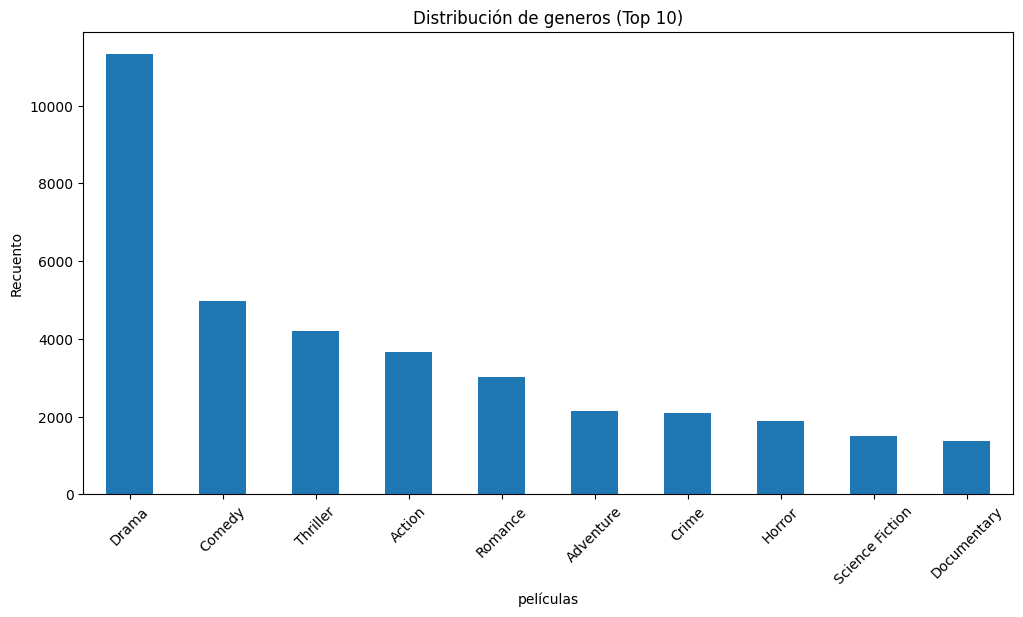

In [65]:
plt.figure(figsize=(12, 6))
df_movies_full['genres'].value_counts().head(10).plot(kind='bar')
plt.title('Distribución de generos (Top 10)')
plt.xlabel('películas')
plt.ylabel('Recuento')
plt.xticks(rotation=45)
plt.show()

#### Grafico 2: Distribución de compañías de producción

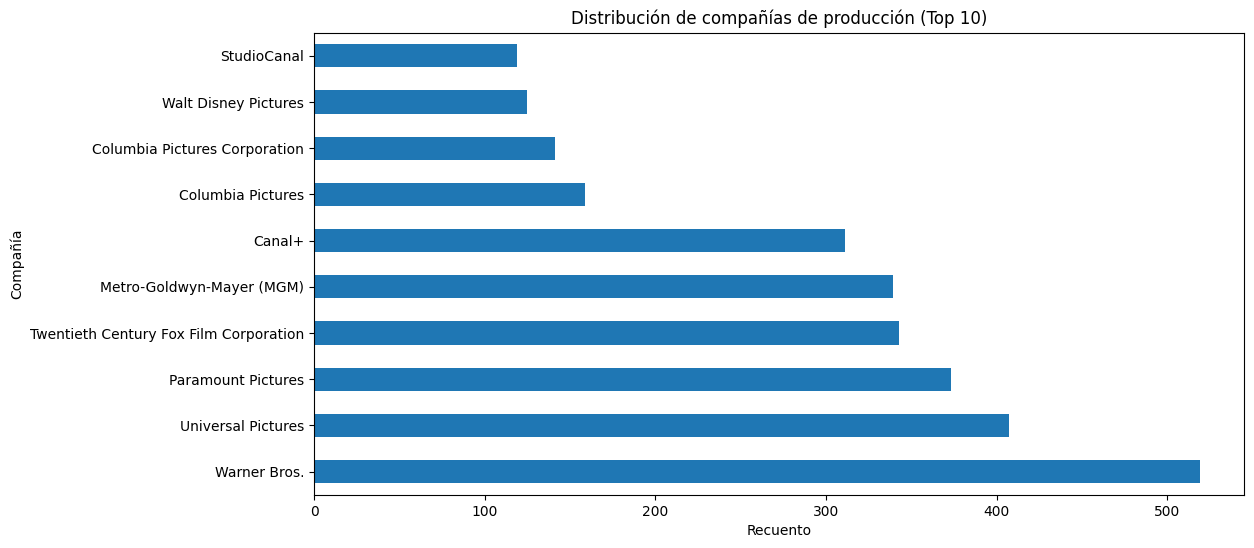

In [66]:
plt.figure(figsize=(12, 6))
df_movies_full['production_companies'].value_counts().head(10).plot(kind='barh')
plt.title('Distribución de compañías de producción (Top 10)')
plt.xlabel('Recuento')
plt.ylabel('Compañía')
plt.show()

#### Grafico 3: Distribución de año de Lanzamiento

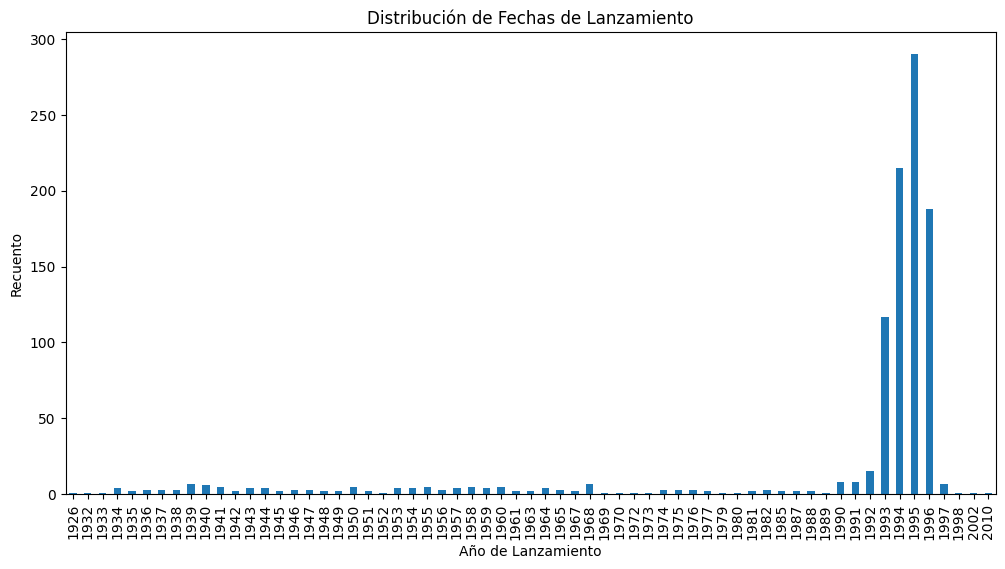

In [67]:
plt.figure(figsize=(12, 6))
df_movies_full['release_date'].dt.year.head(1000).value_counts().sort_index().plot(kind='bar')
plt.title('Distribución de Fechas de Lanzamiento')
plt.xlabel('Año de Lanzamiento')
plt.ylabel('Recuento')
plt.show()

Se observa una gran aumento entro los años 1990 y 1996 para luego desminuir drasticamente llegando a principios del siglo XXI

#### Grafico 4: Distribución de votos por película (Top 10)

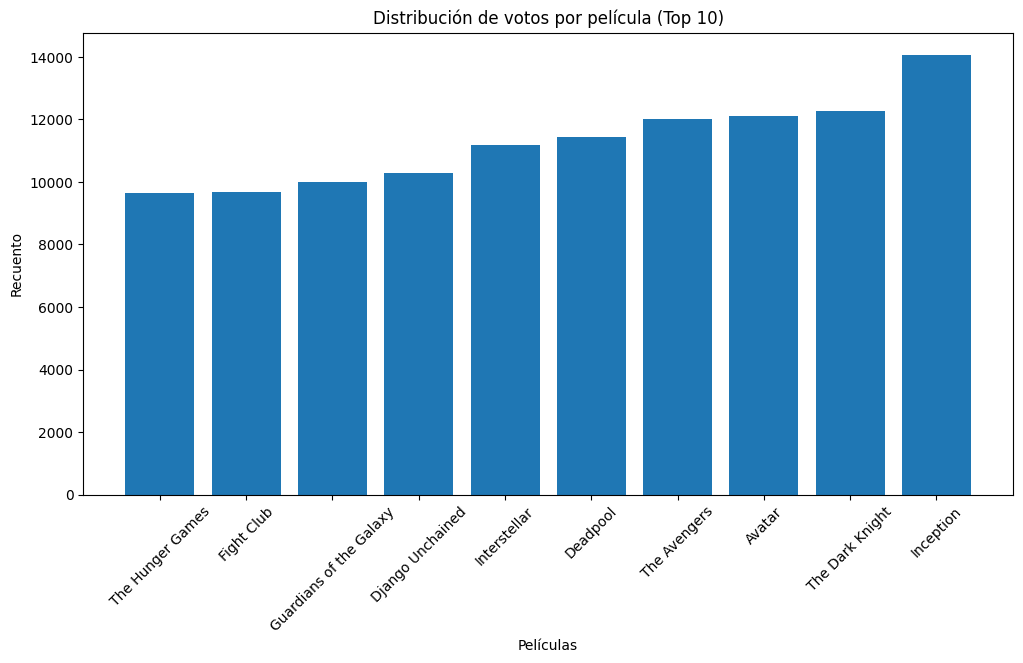

In [68]:
top_10_votes = df_movies_full.nlargest(10, 'vote_count')


top_10_votes = top_10_votes.sort_values('vote_count', ascending=True)
# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(top_10_votes['title'], top_10_votes['vote_count'])
plt.title('Distribución de votos por película (Top 10)')
plt.xlabel('Películas')
plt.ylabel('Recuento')
plt.xticks(rotation=45)
plt.show()

Del grafico 4 se puede ver que la película incepción ha sido la más votada a lo largo de los años

#### Grafico 5: Distribución de ingreso por película (Top 20)

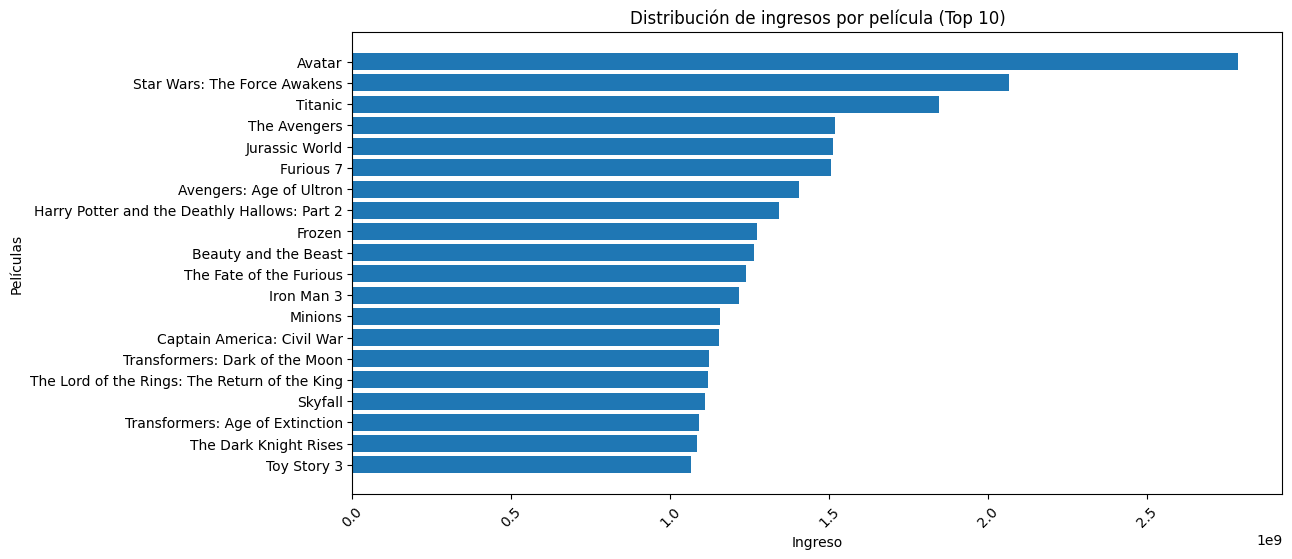

In [69]:
top_20_revenue = df_movies_full.nlargest(20, 'revenue')

top_20_revenue = top_20_revenue.sort_values('revenue', ascending=True)
# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(top_20_revenue['title'], top_20_revenue['revenue'])
plt.title('Distribución de ingresos por película (Top 10)')
plt.xlabel('Ingreso')
plt.ylabel('Películas')
plt.xticks(rotation=45)
plt.show()

#### Grafico 6: Distribución de presupuesto por película (Top 20)

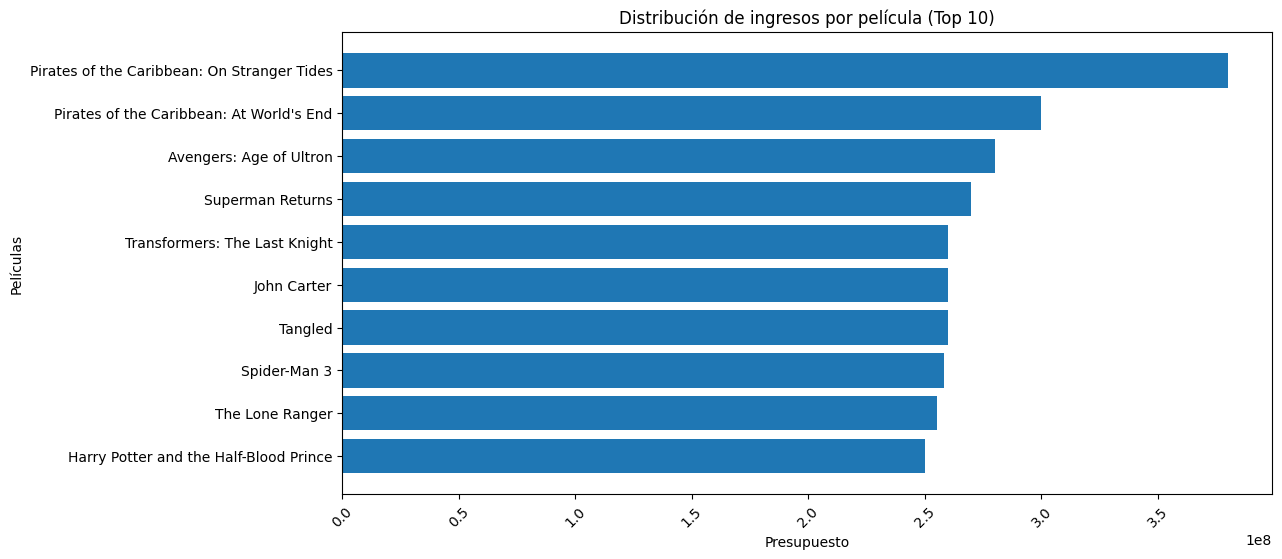

In [70]:
top_10_budget = df_movies_full.nlargest(10, 'budget')

top_10_budget = top_10_budget.sort_values('budget', ascending=True)

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.barh(top_10_budget['title'], top_10_budget['budget'])
plt.title('Distribución de ingresos por película (Top 10)')
plt.xlabel('Presupuesto')
plt.ylabel('Películas')
plt.xticks(rotation=45)
plt.show()

De este grafico se ve que la película que necesito un mayor presupuesto es la de piratas del caribe navegando en aguas misteriosas

#### Grafico 7: Distribución de Retorno por película (Top 10)

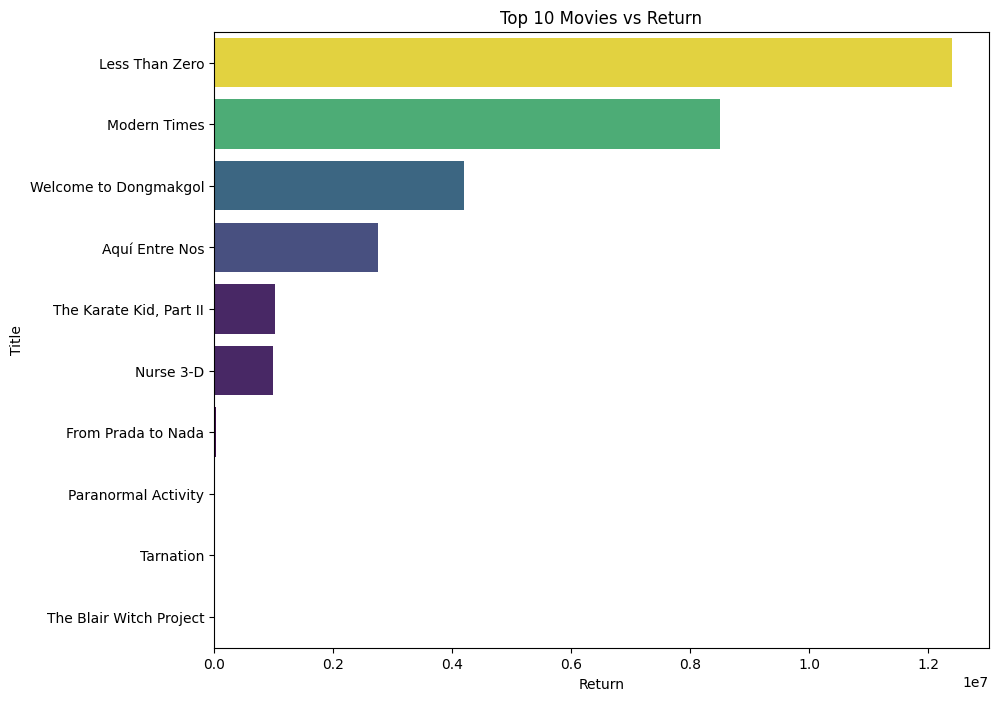

In [71]:
df_top10 = df_movies_full.sort_values(by='return', ascending=False).head(10)

plt.figure(figsize=(10, 8))
sns.barplot(x='return', y='title', hue='return', data=df_top10, palette='viridis', legend=False)
plt.xlabel('Return')
plt.ylabel('Title')
plt.title('Top 10 Movies vs Return')
plt.show()

## 5. Modelamiento para sistema de recomendación

##### para esto se utilizará la librería que contiene la herramienta 'similitud de coseno'

In [72]:
df_movies_full.columns   

Index(['budget', 'id_movie', 'original_language', 'overview', 'popularity',
       'release_date', 'revenue', 'runtime', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'id_genres', 'genres',
       'production_companies', 'id_company', 'country_code',
       'production_countries', 'language_code', 'language', 'release_year',
       'return'],
      dtype='object')

##### con esto es posible medir que tanto se parece una variable con otra con valores de similitud entre -1 y 1, con 1 tendría una similitud muy alta, cero muy baja y -1 muy baja.

##### para esto necesitaremos un nuevo dataframe utilizando 'title', 'id_movie', 'genres'

In [73]:
df_modelo_1 = df_movies_full[['id_movie', 'title', 'genres']].copy()

##### se verifican los cuantos datos nulos presenta cada columna con el fin de verificar si es posible disminuir datos sin afectar la calidad

In [74]:
print(df_modelo_1.shape)
print(df_modelo_1.isnull().sum())
df_modelo = df_modelo_1.dropna()
print(df_modelo.shape)
print(df_modelo.duplicated().sum())

(45346, 3)
id_movie      0
title         0
genres      662
dtype: int64
(44684, 3)
0


se convierten el tipo de dato de 'id_movie' a int

In [75]:
df_modelo.loc[:, 'id_movie'] = df_modelo['id_movie'].astype(int)


In [133]:
df_modelo_final  = pd.get_dummies(df_modelo, columns=['genres'], prefix='genre')

In [134]:
df_modelo_final.head(3)

,id_movie,title,genre_Action,genre_Adventure,genre_Animation,genre_Carousel Productions,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Music,genre_Mystery,genre_Pulser Productions,genre_Romance,genre_Science Fiction,genre_TV Movie,genre_Thriller,genre_Vision View Entertainment,genre_War,genre_Western
0,862.00,Toy Story,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,8844.00,Jumanji,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
21,15602.00,Grumpier Old Men,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False


se reordena el dataframe

In [135]:
df_modelo_final = df_modelo_final.groupby(['id_movie', 'title']).sum().reset_index()


In [136]:
df_modelo_final.shape

(44684, 26)

Se realiza un conteo de las filas ya que el dataframe es demasiado grande como para que se pueda correr el codigo por lo tanto se disminuyen de la siguiente manera:

In [137]:
num_filas = len(df_modelo_final)
df_modelo_final = df_modelo_final.iloc[:num_filas//5]

In [138]:
df_modelo_final.shape

(8936, 26)

In [139]:
df_modelo_final

,id_movie,title,genre_Action,genre_Adventure,genre_Animation,genre_Carousel Productions,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,...,genre_Music,genre_Mystery,genre_Pulser Productions,genre_Romance,genre_Science Fiction,genre_TV Movie,genre_Thriller,genre_Vision View Entertainment,genre_War,genre_Western
0,2.00,Ariel,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3.00,Shadows in Paradise,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,5.00,Four Rooms,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6.00,Judgment Night,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,11.00,Star Wars,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8931,19757.00,Icarus XB 1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8932,19759.00,The Fabulous World of Jules Verne,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8933,19760.00,Two If by Sea,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
8934,19761.00,Saturn 3,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


se procede a realizar la función para las recomendaciones

In [140]:
def recomendacion(titulo):
    
    titulo = titulo.replace(" ", "").lower()
    tfidf_vectorizer = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_modelo_final['title'].values.astype('U'))
    similitudes = cosine_similarity(tfidf_matrix)
    # Filter the input movie by its title
    selected_movie = df_modelo_final[df_modelo_final['title'].str.replace(" ", "").str.lower() == titulo]
    
    if selected_movie.empty:
        return ["Movie with the specified title does not exist in the database."]

        # Get similarity scores of the input movie with all movies
    similarity_scores = similitudes[selected_movie.index[0]]
    
    # Get indices of top 5 most similar movies (excluding the input movie)
    similar_movie_indices = similarity_scores.argsort()[::-1][1:6]
    
    # Get titles of recommended movies
    recommended_movies = df_modelo_final.iloc[similar_movie_indices]['title'].unique().tolist()
    
    recommended_movies = [movie for movie in recommended_movies if movie.replace(" ", "").lower() != titulo]

        # Ensure we have exactly 5 recommendations
    if len(recommended_movies) < 5:
        additional_movies = df_modelo_final[~df_modelo_final['title'].str.replace(" ", "").str.lower().isin([titulo] + recommended_movies)]
        recommended_movies += additional_movies['title'].unique().tolist()[:5 - len(recommended_movies)]
    return recommended_movies


In [141]:
recomendacion('Toy Story')

['Toy Story 2', 'L.A. Story', 'The Story of Us', 'The Story of O', 'Ariel']

#### Se procede a guardar todos los modelos en archivos parquet

In [142]:
#convertimos dataframe a archivo parquet
df_f1.to_parquet('Datasets\df_f1.parquet')
df_f2.to_parquet('Datasets\df_f2.parquet')
df_f3.to_parquet('Datasets\df_f3.parquet')
df_f4.to_parquet('Datasets\df_f4.parquet')
df_f5.to_parquet('Datasets\df_f5.parquet')
df_f6.to_parquet('Datasets\df_f6.parquet')
df_modelo_final.to_parquet('Datasets\df_modelo_final.parquet')